# Pregunta 3: Skill Prediction en LinkedIN

## a) Generación de matriz dispersa Z

In [1]:
from scipy.sparse import csr_matrix
import numpy as np

def generar_matriz():

    lineas_perfiles = [linea.rstrip('\n') for linea in open('user_skill')]
    lineas_competencias = [linea.rstrip('\n') for linea in open('skill_id')]

    n = len(lineas_perfiles)
    d = len(lineas_competencias)
    
    matriz = csr_matrix((n, d), dtype=np.int8).toarray()
    
    perfiles = [perfil.split(":") for perfil in lineas_perfiles]
    perfiles = [(perfil[0],perfil[1].split(",")) for perfil in perfiles]
    
    for perfil in perfiles:
        id_perfil = int(perfil[0])
        for skill in perfil[1]:
            id_skill = int(skill)
            matriz[id_perfil][id_skill] = 1
        
    return matriz
    
matriz = generar_matriz()
matriz.shape

(7890L, 14544L)

## b) Sub-matrices de entrenamiento y de prueba

In [2]:
import random

matriz_aux = random.sample(matriz, len(matriz)) 
n = len(matriz_aux)

matriz_train = np.asmatrix(matriz_aux[:int(n*0.7)])
matriz_test = np.asmatrix(matriz_aux[int(n*0.7):])

n_tr = len(matriz_train)
n_ts = len(matriz_test)

Si bien se barajan los registros de la matriz para generar submatrices aleatorias, se asigna un valor fijo de un 70% de ellos para el conjunto de entrenamiento, para así generar un modelo bien entrenado y a la vez dejando una cantidad considerable de datos de prueba para determinar el rendimiento del mismo.

## c) Frecuencia de competencias

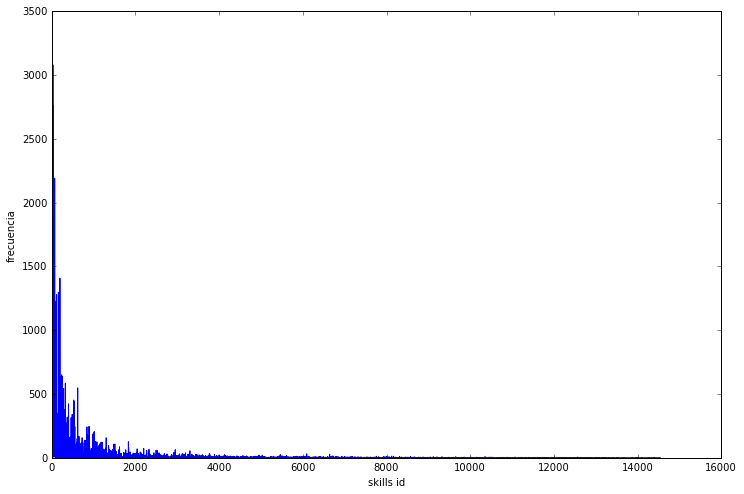

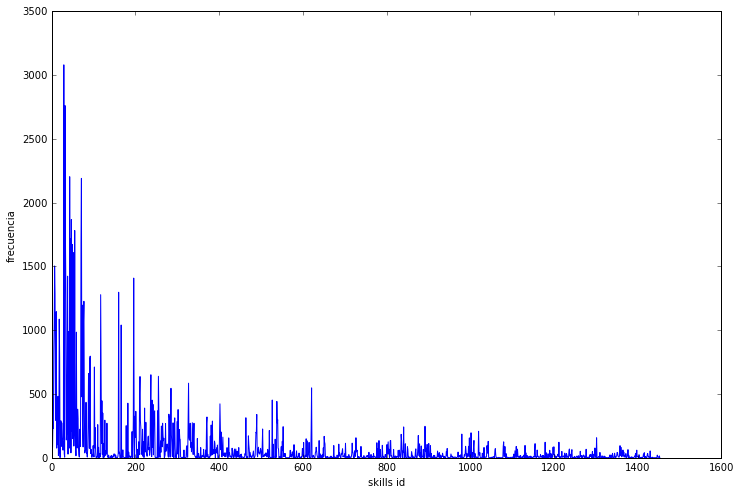

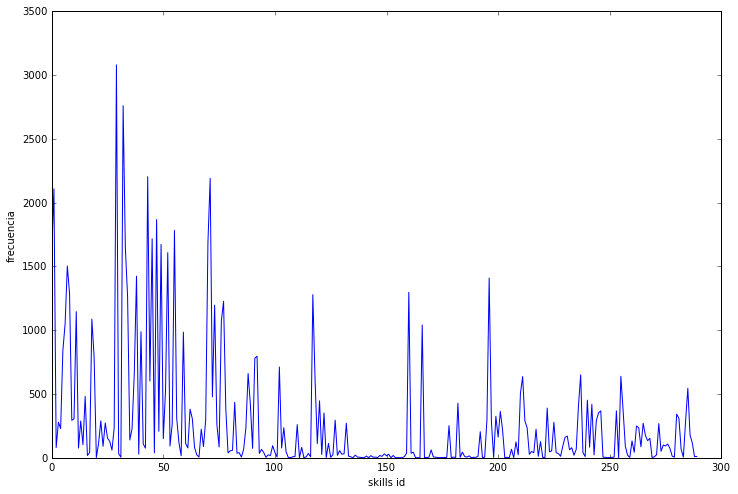

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

frec_skills = matriz.sum(axis=0)
d=len(matriz.sum(axis=0))

corte=1
plt.figure(figsize=(12, 8))
plt.plot(range(0,int(corte*d)), frec_skills[:int(corte*d)])
plt.ylabel('frecuencia')
plt.xlabel('skills id')
plt.show()

corte=0.1
plt.figure(figsize=(12, 8))
plt.plot(range(0,int(corte*d)), frec_skills[:int(corte*d)])
plt.ylabel('frecuencia')
plt.xlabel('skills id')
plt.show()

corte=0.02
plt.figure(figsize=(12, 8))
plt.plot(range(0,int(corte*d)), frec_skills[:int(corte*d)])
plt.ylabel('frecuencia')
plt.xlabel('skills id')
plt.show()

Los primeros identificadores de competencias se repiten con más frecuencia, en especial los primeros 2000. Se acerca cada vez más el gráfico para revisar de cerca la distribución de frecuencia.

## d) Generación de matrices de entrenamiento y prueba

In [13]:
def generar_matrices_tr_ts(skill_id_chosen):

    X_tr = np.delete(matriz_train, [skill_id_chosen], axis=1)
    y_tr = matriz_train[:, [skill_id_chosen]]

    X_ts = np.delete(matriz_test, [skill_id_chosen], axis=1)
    y_ts = matriz_test[:, [skill_id_chosen]]

    y_tr = np.ravel(y_tr)
    y_ts = np.ravel(y_ts)
    
    return X_tr, y_tr, X_ts, y_ts

## e) Entrenamiento y evaluación de clasificadores

In [14]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

def train_eval_models(X_tr, y_tr, X_ts, y_ts):

    model_BNB = BernoulliNB()
    model_BNB = model_BNB.fit(X_tr, y_tr)
    acc_tr_BNB = model_BNB.score(X_tr,y_tr)
    acc_ts_BNB = model_BNB.score(X_ts,y_ts)

    model_MNB = MultinomialNB()
    model_MNB = model_MNB.fit(X_tr, y_tr)
    acc_tr_MNB = model_MNB.score(X_tr,y_tr)
    acc_ts_MNB = model_MNB.score(X_ts,y_ts)

    model_GNB = GaussianNB()
    model_GNB = model_GNB.fit(X_tr, y_tr)
    acc_tr_GNB = model_GNB.score(X_tr,y_tr)
    acc_ts_GNB = model_GNB.score(X_ts,y_ts)

    Cs = [0.01,0.1,10,100,1000]
    acc_ts_LR = 0
    for C in Cs:
        model_LR = LogisticRegression(penalty='l2',C=C)
        model_LR = model_LR.fit(X_tr, y_tr)
        if model_LR.score(X_ts,y_ts) > acc_ts_LR:
            acc_tr_LR = model_LR.score(X_tr,y_tr)
            acc_ts_LR = model_LR.score(X_ts,y_ts)

    Cs = [0.01,0.1,10,100,1000]
    acc_ts_SVC = 0
    for C in Cs:
        model_SVC = LinearSVC(C=C)
        model_SVC = model_SVC.fit(X_tr, y_tr)
        if model_SVC.score(X_ts,y_ts) > acc_ts_SVC:
            acc_tr_SVC = model_SVC.score(X_tr,y_tr)
            acc_ts_SVC = model_SVC.score(X_ts,y_ts)
    
    return ((acc_tr_BNB,acc_tr_MNB,acc_tr_GNB,acc_tr_LR,acc_tr_SVC),(acc_ts_BNB,acc_ts_MNB,acc_ts_GNB,acc_ts_LR,acc_ts_SVC))

Se utilizan 5 modelos: Bernoulli Naive Bayes, Multinomial Naive Bayes, Gaussian Naive Bayes, Logistic Regression y Linear SVC.

Para los dos úlimos se itera entre 5 valores de regularización distintos hasta encontrar el que entregue el mayor valor de prueba, entregando como puntaje final la predicción con dicho parámetro.

## f) Comparacion de modelos entre distintas competecias

In [34]:
def generar_grafico_comparativo(id_skill):

    X_tr, y_tr, X_ts, y_ts = generar_matrices_tr_ts(id_skill)

    train_scores, test_scores = train_eval_models(X_tr, y_tr, X_ts, y_ts)

    N = len(train_scores)

    ind = np.arange(N) 
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, train_scores, width, color='r')
    rects2 = ax.bar(ind + width, test_scores, width, color='y')

    ax.set_ylabel('Scores')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('BNB', 'MNB', 'GNB', 'LR', 'SVC'))

    plt.show()

Los gráficos generados muestran el puntaje del conjunto de entrenamiento y de prueba para cada caso. En rojo el score para entrenamiento y en verde el de prueba.

Business Intelligence:


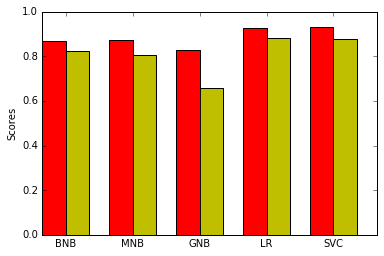


Team Leadership


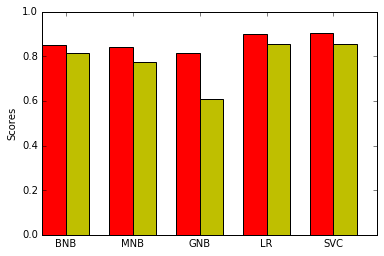


Telecommunications


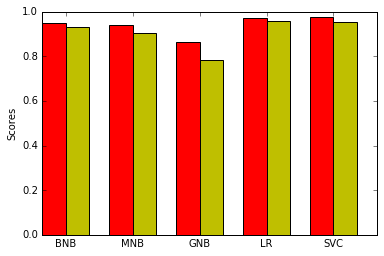


Java


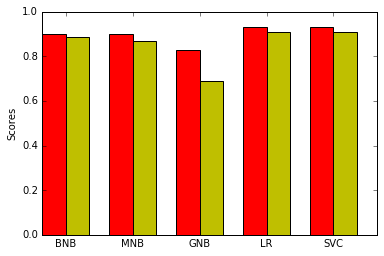


PHP


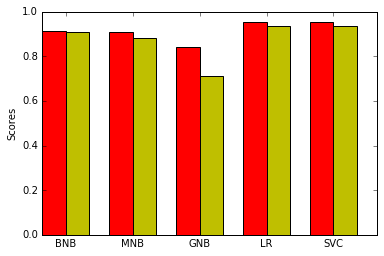

In [35]:
print "Business Intelligence:"
generar_grafico_comparativo(0)
print
print "Team Leadership"
generar_grafico_comparativo(1)
print
print "Telecommunications"
generar_grafico_comparativo(15)
print
print "Java"
generar_grafico_comparativo(8)
print
print "PHP"
generar_grafico_comparativo(6)

Para todos los resultados el modelo SVM y el de regresión logística presentan los mejores resultados con valores similares. Gaussian Naive Bayes resulta ser un modelo que no ajusta bien los datos ya que entrega el peor resultado en todos los casos.

Telecommunications es la competencia que logra ser predicha con mayor presicicón, donde la regresión logística genera un modelo con score cercano a 97% para el conjunto de prueba.

Los modelos con regularización son los que resultan ser mejores para la naturaleza de los datos. Además en general los modelos se sobreajustan poco, por lo que los resultados finales del ejercicio son bastante satisfactorios. Y las competencias entregadas por un usuario sí son información relevantes para predecir más competencias.